In [ ]:
!pip install mujoco

# Set up GPU rendering.
from google.colab import files
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import numpy as np
from typing import Callable, Optional, Union, List
import scipy.linalg
import math
import time
import copy
import numpy.typing as npt

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

# Understanding MuJoCo: An Advanced Physics Engine

MuJoCo, which stands for Multi-Joint dynamics with Contact, is a cutting-edge physics engine designed to aid in research and development in various fields, including robotics, biomechanics, graphics, and animation. It is renowned for its speed, accuracy, and powerful modeling capabilities, making it a valuable tool for both academic and practical applications.

# Load and Render the Franka Emika Panda

The provided code sets up the MuJoCo environment for simulating and visualizing a Panda robot model.
The XML is used to instantiate an `MjModel`. Given the model, we can create an `MjData` which holds the simulation state, and an instance of the `Renderer` class defined above.
 - mujoco.MjModel.from_xml_string(xml): Creates a MuJoCo model from the XML string. This model includes the physical properties, kinematics, and dynamics of the Panda robot.
 - mujoco.MjData(model): Initializes the MuJoCo data object associated with the model. This object contains the simulation state, including positions, velocities, forces, and other dynamic properties.
 - mujoco.Renderer(model): Initializes the renderer object for visualizing the MuJoCo model. This object will handle the rendering of the model's simulation in a 3D graphical window.

In [ ]:
# Clone the repository containing the Panda robot model and related assets
!git clone https://github.com/SouthColumn76/panda_mjcf
# Copy the assets directory from the cloned repository to the current working directory
!cp -r panda_mjcf/assets ./assets

# Open and read the XML file defining the Panda robot model
with open('panda_mjcf/panda_4cube.xml', 'r') as fp:
  xml = fp.read()

# Create a MuJoCo model instance from the XML string
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

Cloning into 'panda_mjcf'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 116 (delta 24), reused 101 (delta 12), pack-reused 0
Receiving objects: 100% (116/116), 7.63 MiB | 5.64 MiB/s, done.
Resolving deltas: 100% (24/24), done.


The state in the `data` object is in the default configuration. Let's invoke the forward dynamics to populate all the derived quantities (like the positions of geoms in the world), update the scene and render it:
- mujoco.mj_forward(model, data): This function computes the forward dynamics of the model. It updates the state of the simulation based on the current positions, velocities, and forces acting on the model. Essentially, it advances the simulation by one time step, considering the physics and constraints defined in the model.
- renderer.update_scene(data): This function updates the renderer with the latest simulation data. It prepares the scene for rendering by incorporating the current state of the simulation (positions, orientations, etc.) into the graphical representation.
- renderer.render(): This function renders the current scene, generating an image based on the updated simulation data. It produces a visual representation of the model and its environment as defined by the current state.
- media.show_image(renderer.render()): This function displays the rendered image using a media display tool. It takes the image produced by renderer.render() and shows it in an appropriate viewer, making the simulation's visual output accessible to the user.

""

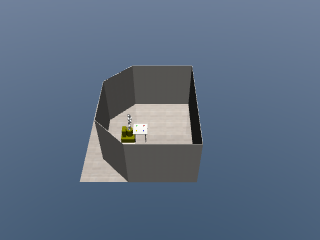

In [ ]:
# Perform a forward dynamics computation to update the simulation state
mujoco.mj_forward(model, data)

# Update the renderer with the current simulation data
renderer.update_scene(data)

# Render the current scene and display the resulting image
media.show_image(renderer.render())

Because it is far away, the robot cannot be seen in detail.

Mujoco can use multiple cameras.
Let's check the cameras currently in this XML and render using each one.

frontview


""

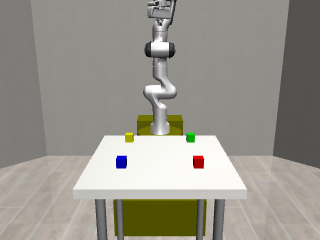

birdview


""

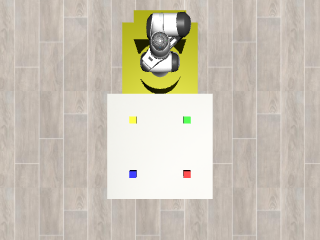

agentview


""

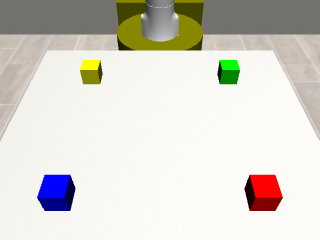

sideview


""

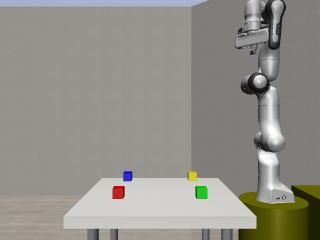

targetview


""

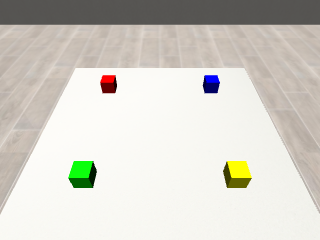

In [ ]:
for i in range(model.ncam):
  print(model.camera(i).name)
  renderer.update_scene(data, camera=i)
  media.show_image(renderer.render())

When specifying a camera, we can use not only the number but also the name.

""

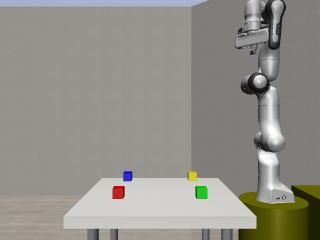

In [ ]:
renderer.update_scene(data, camera='sideview')
media.show_image(renderer.render())

## Actuator Control

The model comes with some built-in "keyframes" which are saved simulation states.

`mj_resetDataKeyframe` can be used to load them. Let's see what they look like:

- mujoco.mj_resetDataKeyframe(model, data, key): This function resets the simulation data to match the state defined by the specified keyframe. Keyframes are predefined states of the model, and this function sets the simulation to these states, one by one, as the loop iterates.

""

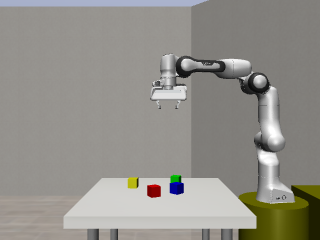

In [ ]:
for key in range(model.nkey):
  mujoco.mj_resetDataKeyframe(model, data, key)
  mujoco.mj_forward(model, data)
  renderer.update_scene(data, camera='sideview')
  media.show_image(renderer.render())

Now let's simulate the physics and render to make a video.

In [ ]:
DURATION  = 3   # seconds
FRAMERATE = 60  # Hz

# Initialize pose.
mujoco.mj_resetDataKeyframe(model, data, 0)

frames = []
while data.time < DURATION:
  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data, camera='sideview')
    pixels = renderer.render()
    frames.append(pixels)

# Display video.
media.show_video(frames, fps=FRAMERATE)

Since the model is defined as built-in torque actuators, without control, the posture cannot be maintained due to gravity.

we can use to drive the robot's joints by setting the `data.ctrl` vector.

### How to find the relationship between joint and actuator

In XML, not only robots but all movable objects have joints. Among them, the only joints that can be controlled are those connected to the actuator.

To find out which joints an actuator can control, check the actuator's transmission type and ID.

In [ ]:
model.actuator(0).trntype, model.actuator(0).trnid

(array([0], dtype=int32), array([ 4, -1], dtype=int32))

In this XML, the transmission type of each joint of the robot is `mjTRN_JOINT` and the finger of the end-effector is `mjTRN_TENDON`.

In [ ]:
mujoco.mjtTrn.mjTRN_JOINT, mujoco.mjtTrn.mjTRN_TENDON

(<mjtTrn.mjTRN_JOINT: 0>, <mjtTrn.mjTRN_TENDON: 3>)

#PID Controller Class

**Specifications**:
1. Class Definition:
  - Class Name: PIDController
2. Constructor Parameters:
  - k_p: Proportional gain (default: 0.01)
  - k_i: Integral gain (default: 0.0)
  - k_d: Derivative gain (default: 0.001)
  - dt: Time step (default: 0.01)
  - dim: Dimensionality of the controller (default: 1)
  - dt_min: Minimum time step to avoid division by zero (default: 1e-6)
  - out_min: Minimum output value (default: -infinity)
  - out_max: Maximum output value (default: infinity)
  - ANTIWU: Boolean to enable or disable anti-windup (default: True)
  - out_alpha: Smoothing factor for output EMA (default: 0.0)
3. Methods:
  - reset(self, t_curr=0.0): Resets the internal state of the controller.
  - update(self, x_curr, t_curr, x_trgt=None): Updates the controller state and computes the control output based on the current and target states and the current time.
  - out(self): Returns the current control output value.

In [ ]:
class PIDController:
  def __init__(self,
               k_p       = 0.01,
               k_i       = 0.0,
               k_d       = 0.001,
               dt        = 0.01,
               dim       = 1,
               dt_min    = 1e-6,
               out_min   = -np.inf,
               out_max   = np.inf,
               ANTIWU    = True,   # anti-windup
               out_alpha = 0.0    # output EMA (0: no EMA)
              ) -> None:
    self.k_p       = np.ones(shape=dim) * k_p
    self.k_i       = np.ones(shape=dim) * k_i
    self.k_d       = np.ones(shape=dim) * k_d
    self.dt        = dt
    self.dim       = dim
    self.dt_min    = dt_min
    self.out_min   = out_min
    self.out_max   = out_max
    self.ANTIWU    = ANTIWU
    self.out_alpha = out_alpha

    # Buffers
    self.reset()

  def reset(self,t_curr = 0.0) -> None:
    self.cnt      = 0
    self.x_trgt   = np.zeros(shape=self.dim)
    self.x_curr   = np.zeros(shape=self.dim)
    self.out_val  = np.zeros(shape=self.dim)
    self.out_val_prev = np.zeros(shape=self.dim)
    self.t_curr   = t_curr
    self.t_prev   = t_curr
    self.err_curr = np.zeros(shape=self.dim)
    self.err_intg = np.zeros(shape=self.dim)
    self.err_prev = np.zeros(shape=self.dim)
    self.p_term   = np.zeros(shape=self.dim)
    self.d_term   = np.zeros(shape=self.dim)
    self.err_out  = np.zeros(shape=self.dim)

  def update(self, x_curr, t_curr, x_trgt = None) -> None:
    """
        Update PID controller
        u(t) = K_p e(t) + K_i int e(t) {dt} + K_d {de}/{dt}
    """
    if x_trgt is not None:
      self.x_trgt  = x_trgt
    if t_curr is not None:
      self.t_curr  = t_curr
    if x_curr is not None:
      self.x_curr  = x_curr
      # PID controller updates here
      self.dt       = max(self.t_curr - self.t_prev,self.dt_min)
      self.err_curr = self.x_trgt - self.x_curr
      self.err_intg = self.err_intg + (self.err_curr*self.dt)
      self.err_diff = self.err_curr - self.err_prev

      if self.ANTIWU: # anti-windup
        self.err_out = self.err_curr * self.out_val
        self.err_intg[self.err_out<0.0] = 0.0

      if self.dt > self.dt_min:
        self.p_term   = self.k_p * self.err_curr
        self.i_term   = self.k_i * self.err_intg
        self.d_term   = self.k_d * self.err_diff / self.dt
        self.out_val  = np.clip(
          a     = self.p_term + self.i_term + self.d_term,
          a_min = self.out_min,
          a_max = self.out_max)
        # Smooth the output control value using EMA
        self.out_val = self.out_alpha*self.out_val_prev + \
          (1.0-self.out_alpha)*self.out_val
        self.out_val_prev = self.out_val

      # Backup
      self.t_prev   = self.t_curr
      self.err_prev = self.err_curr
    # Counter
    if (t_curr is not None) and (x_curr is not None):
      self.cnt = self.cnt + 1

  def out(self) -> npt.NDArray:
    return self.out_val

The current status of robot joints required to use the PID controller can be known through `data.qpos`.

Since `data.qpos` is the state vector of all joints in XML, we need to find the qpos of the joints connected to the actuator.

In [ ]:
model.nu # number of actuators/controls = dim(ctrl)
joint_ids = []
ctrl_adrs = []
for id in range(model.nu):
    if model.actuator(id).trntype[0] == mujoco.mjtTrn.mjTRN_JOINT:
        joint_ids.append(model.actuator(id).trnid[0])
        ctrl_adrs.append(id)
qpos_adrs = model.jnt_qposadr[joint_ids]

In [ ]:
DURATION  = 3   # seconds
FRAMERATE = 60  # Hz

# Initialize pose.
mujoco.mj_resetDataKeyframe(model, data, 0)

# Initialize PID Controller
pid_controller = PIDController(k_p=1000, k_i=0.1, k_d=50, dim=7, out_min=model.actuator_ctrlrange[ctrl_adrs, 0], out_max=model.actuator_ctrlrange[ctrl_adrs, 1])
pid_controller.x_trgt = data.qpos[qpos_adrs].copy()

frames = []
while data.time < DURATION:
  # Step the simulation.
  x_curr = data.qpos[qpos_adrs].copy()
  pid_controller.update(x_curr, data.time)
  data.ctrl[ctrl_adrs] = pid_controller.out()
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data, camera='sideview')
    pixels = renderer.render()
    frames.append(pixels)

# Display video.
media.show_video(frames, fps=FRAMERATE)

# Utility Functions

Robot body and joint are important in kinematics. Like actuators, bodies also have a relationship with joints.

In [ ]:
body_id = model.body('link1').id
joint_id = model.body_jntadr[body_id]

Since mujoco represent the relationship between each body as a kinematic tree, we can easily find the entire body and joint using the body id or name of the end-effector.

In [ ]:
for body_id in range(model.nbody):
  print(model.body(body_id).name)

world
table
red_cube
blue_cube
green_cube
yellow_cube
robot_fixed
mount_base
mount0_controller_box
mount_pedestal_feet
mount_torso
mount_pedestal
link0
link1
link2
link3
link4
link5
link6
link7
hand
grasp_site
left_finger
right_finger


Some utility functions

In [ ]:
def get_body_ids(model: mujoco.MjModel, eef: str | int) -> list[int]:
  eef_id = model.body(eef).id
  body_ids = [eef_id]
  body_id = eef_id
  tree_id = model.body_treeid[eef_id]
  for _ in range(model.nbody):
    parent_id = model.body(body_id).parentid[0]
    if model.body_treeid[parent_id] == tree_id:
      body_ids.append(parent_id)
      body_id = body_ids[-1]
    else:
      break
  else:
    raise ValueError(f'body {eef_id} not in tree of kinematics chain.')
  body_ids.reverse()
  return body_ids

def get_qpos_adrs(model: mujoco.MjModel, body_ids: list[int]) -> list[int]:
  jnt_ids = model.body_jntadr[body_ids]
  jnt_ids = [id for id in jnt_ids if id != -1]
  qpos_adrs = model.jnt_qposadr[jnt_ids]
  return qpos_adrs

def get_qvel_adrs(model: mujoco.MjModel, body_ids: list[int]) -> list[int]:
  jnt_ids = model.body_jntadr[body_ids]
  jnt_ids = [id for id in jnt_ids if id != -1]
  dof_adrs = model.jnt_dofadr[jnt_ids]
  return dof_adrs

body_ids = get_body_ids(model, eef='hand')
qpos_adrs = get_qpos_adrs(model, body_ids)
qvel_adrs = get_qvel_adrs(model, body_ids)
print('\n'.join([f'body name: {model.body(body_id).name}, bodt id: {body_id} , qpos adress: {qpos_adrr}, qvel adress: {qvel_adrr}' for body_id, qpos_adrr, qvel_adrr in zip(body_ids, qpos_adrs, qvel_adrs)]))

body name: link1, bodt id: 13 , qpos adress: 28, qvel adress: 24
body name: link2, bodt id: 14 , qpos adress: 29, qvel adress: 25
body name: link3, bodt id: 15 , qpos adress: 30, qvel adress: 26
body name: link4, bodt id: 16 , qpos adress: 31, qvel adress: 27
body name: link5, bodt id: 17 , qpos adress: 32, qvel adress: 28
body name: link6, bodt id: 18 , qpos adress: 33, qvel adress: 29
body name: link7, bodt id: 19 , qpos adress: 34, qvel adress: 30


### Kinematics in Mujoco
Three components are required to create an RRT* planner and a Cartesian planner.

* Sampler:  
  RRT* is a sampling-based planner, so it requires the ability to generate random samples. Additionally, it serves to check whether the given state is valid.
* Collision Checker:  
  It is necessary to check whether a conflict occurs in a given state.
* Kinematics:  
  It is responsible for calculating forward and inverse kinematics.

#### Sampler

In [ ]:
class Sampler:
  def __init__(self, model: mujoco.MjModel, body_ids: list[int]) -> None:
    joint_mins = []
    joint_maxs = []
    for id in body_ids:
      joint_id = model.body(id).jntadr[0]
      if joint_id == -1:
        continue
      joint_range = model.joint(joint_id).range
      joint_mins.append(joint_range[0])
      joint_maxs.append(joint_range[1])
    self.joint_mins = np.array(joint_mins)
    self.joint_maxs = np.array(joint_maxs)

  def __call__(self) -> npt.NDArray:
    return np.random.uniform(low=self.joint_mins, high=self.joint_maxs)

  def __contains__(self, item: npt.NDArray) -> bool:
    return np.all((item >= self.joint_mins) & (item <= self.joint_maxs))

In [ ]:
sampler = Sampler(model, body_ids)

sample = sampler()
print(sample)

sample += np.random.normal(0, 1, sample.shape)
print(sample in sampler)

[ 1.174  0.952  0.327 -2.768 -0.21   1.505  2.587]
False


""

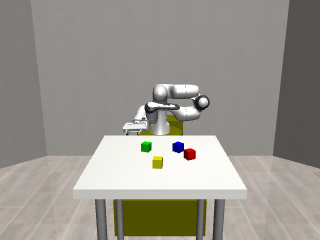

In [ ]:
def get_image_of_pos(qpos, camera: str | int = 'frontview'):
  data.qpos[qpos_adrs] = qpos
  mujoco.mj_kinematics(model, data)
  renderer.update_scene(data, camera=camera)
  return renderer.render()

media.show_image(get_image_of_pos(sample))

# Collision Checker

**Specifications**:
1. Class Definition:

  - Class Name: CollisionChecker
2. Constructor Parameters:

  - model: An instance of mujoco.MjModel representing the MuJoCo model.
  - body_ids: A list of body IDs to consider for collision checking.
  - ignore_pairs: An optional list of tuples, each containing two geometry names to ignore during collision detection.
3. Methods:

  - `__init__`(self, model: mujoco.MjModel, body_ids: list[int], ignore_pairs: list[tuple] = None): Initializes the collision checker with the given model, body IDs, and ignore pairs.
  - set_qpos(self, data: mujoco.MjData): Updates the internal state of the collision checker with the given simulation data.
  - `__call__`(self, sample: npt.NDArray, print_col: bool = False) -> bool: Checks for collisions given a sample configuration and optionally prints collision details.
4. Functional Requirements:

  - The collision checker should update the model's configuration using the provided sample.
  - Perform collision detection using MuJoCo's collision functions.
  - Optionally ignore specified pairs of geometries during collision detection.
  - Optionally print details of collisions if specified.
  - Return a boolean indicating whether a collision was detected (excluding ignored pairs).

In [ ]:
class CollisionChecker:
  def __init__(self, model: mujoco.MjModel, body_ids: list[int], ignore_pairs: list[tuple] = None) -> None:
    self.model = model
    self.data = mujoco.MjData(model)
    self.qpos_adrs = get_qpos_adrs(model, body_ids)
    self.ignore = False
    if ignore_pairs:
      self.ignore = True
      self.ignore_pairs = [set((model.geom(first).id, model.geom(second).id)) for first, second in ignore_pairs]

  def set_qpos(self, data: mujoco.MjData) -> None:
      self.data.qpos[:] = data.qpos.copy()

  def __call__(self, sample: npt.NDArray, print_col: bool = False) -> bool:
    self.data.qpos[self.qpos_adrs] = sample

    mujoco.mj_kinematics(self.model, self.data)
    mujoco.mj_collision(self.model, self.data)
    ncon = self.data.ncon

    if print_col:
      for contact in self.data.contact:
        print('collied between',
              f'{self.model.body(self.model.geom(contact.geom1).bodyid[0]).name}:{self.model.geom(contact.geom1).name} and',
              f'{self.model.body(self.model.geom(contact.geom2).bodyid[0]).name}:{self.model.geom(contact.geom2).name}')

    if self.ignore:
      for contact in self.data.contact:
        pair = set((contact.geom1, contact.geom2))
        if pair in self.ignore_pairs:
          ncon -= 1

    return ncon != 0

In [ ]:
collision = CollisionChecker(model, body_ids)
sample = sampler()
print(sample, not collision(sample, print_col=True))

[ 2.206  0.704  0.168 -1.467 -2.013  0.558  1.909] True


#### Kinematics

Use jacobian when doing inverse. In this case, `dof_adrs` must be used, because the qpos size of the free joint is 7, but the qvel size is 6. mujoco jacobian uses dof adrs because it deals with velocity values.
For reference, the total number of qpos is `model.nq` and the total number of qvel is `model.nv`.

In [ ]:
def rot_to_omega(R, threshold):
  el = np.array([[R[2, 1] - R[1, 2]], [R[0, 2] - R[2, 0]], [R[1, 0] - R[0, 1]]])
  norm_el = np.linalg.norm(el)
  if norm_el > threshold:
    w = np.dot(np.arctan2(norm_el, np.trace(R) - 1) / norm_el, el)
  elif R[0, 0] > 0 and R[1, 1] > 0 and R[2, 2] > 0:
    w = np.zeros((3, 1))
  else:
    w = np.dot(np.pi / 2, np.array([[R[0, 0] + 1], [R[1, 1] + 1], [R[2, 2] + 1]]))
  return w

def calc_pose_error(target_pos, target_rot, current_pos, current_rot, threshold):
  pos_diff = target_pos - current_pos
  rot_diff = np.dot(current_rot.T, target_rot)
  w_err = np.dot(current_rot, rot_to_omega(rot_diff, threshold))
  return np.vstack((pos_diff.reshape([-1, 1]), w_err))

class Kinematics:
  def __init__(self, model: mujoco.MjModel, body_ids: list[int]) -> None:
    self.model = model
    self.body_ids = body_ids

  def forward(self, qpos: npt.NDArray, eef_id: int = None) -> npt.NDArray:
    body_ids = self.body_ids
    if eef_id:
      body_ids = self.get_sub_body_ids(eef_id)
    qpos_adrs = get_qpos_adrs(self.model, body_ids)
    if len(qpos_adrs) != len(qpos):
      raise ValueError(f'shape mismatch: qpos array of shape {qpos.shape} could not be broadcast to qpos addresses of shape ({len(qpos_adrs)},)')

    fk_data = mujoco.MjData(self.model)
    fk_data.qpos[qpos_adrs] = qpos
    mujoco.mj_forward(self.model, fk_data)
    pos = fk_data.body(body_ids[-1]).xpos.copy()
    quat = fk_data.body(body_ids[-1]).xquat.copy()
    rot = fk_data.body(body_ids[-1]).xmat.reshape([3,3]).copy()
    return pos, quat, rot

  def inverse(self, init_qpos: npt.NDArray, goal_pos: npt.NDArray, goal_rot: npt.NDArray, eef_id: int = None, max_iter: int = 10, threshold: float = 1e-8) -> npt.NDArray:
    body_ids = self.body_ids
    if eef_id:
      body_ids = self.get_sub_body_ids(eef_id)
    qpos_adrs = get_qpos_adrs(self.model, body_ids)
    if len(qpos_adrs) != len(init_qpos):
      raise ValueError(f'shape mismatch: qpos array of shape {init_qpos.shape} could not be broadcast to qpos addresses of shape ({len(qpos_adrs)},)')
    # Jacobian address
    qvel_adrs = get_qvel_adrs(self.model, body_ids)

    dof = self.get_total_dof_of_body_ids(body_ids)
    nv = self.model.nv
    wn_pos = 1 / 0.3
    wn_ang = 1 / (2 * np.pi)
    We = np.diag([wn_pos, wn_pos, wn_pos, wn_ang, wn_ang, wn_ang])
    Wn = np.eye(dof)

    current_qpos = init_qpos.copy()
    ik_data = mujoco.MjData(self.model)
    ik_data.qpos[qpos_adrs] = current_qpos
    mujoco.mj_forward(self.model, ik_data)
    current_pos = ik_data.body(body_ids[-1]).xpos.copy()
    current_rot = ik_data.body(body_ids[-1]).xmat.copy().reshape([3,3])
    err = calc_pose_error(goal_pos, goal_rot, current_pos, current_rot, threshold)
    Ek = np.dot(np.dot(err.T, We), err)[0][0]
    jacp = np.zeros((3, nv))
    jacr = np.zeros((3, nv))

    for _ in range(max_iter):
      lamb = Ek + 0.002
      mujoco.mj_jac(self.model, ik_data, jacp, jacr, current_pos, body_ids[-1])
      J = np.vstack([jacp[:, qvel_adrs[0]:qvel_adrs[0]+dof], jacr[:, qvel_adrs[0]:qvel_adrs[0]+dof]])
      JT = np.dot(np.dot(J.T, We), J)
      J_dls = JT + np.dot(np.diag(np.diag(JT)), lamb)

      gerr = np.dot(np.dot(J.T, We), err)
      dq = np.dot(np.linalg.inv(J_dls), gerr)
      current_qpos += dq.reshape([-1])

      ik_data.qpos[qpos_adrs] = current_qpos
      mujoco.mj_forward(self.model, ik_data)
      current_pos = ik_data.body(body_ids[-1]).xpos.copy()
      current_rot = ik_data.body(body_ids[-1]).xmat.copy().reshape([3,3])
      err = calc_pose_error(goal_pos, goal_rot, current_pos, current_rot, threshold)
      Ek2 = np.dot(np.dot(err.T, We), err)[0][0]
      if Ek2 <= threshold:
        print(Ek)
        break
      elif Ek2 < Ek:
        Ek = Ek2
      else:
        current_qpos -= dq.reshape([-1])
        print(Ek)
        break
    else:
      current_qpos = None
    return current_qpos

  def get_sub_body_ids(self, eef_id: int) -> list[int]:
    body_ids = [eef_id]
    body_id = eef_id
    for _ in range(self.model.nbody):
      parent_id = self.model.body(body_id).parentid
      body_ids.append(parent_id[0])
      body_id = body_ids[-1]
      if body_id == self.body_ids[0]:
        break
    else:
      raise ValueError(f'body {eef_id} not in tree of kinematics chain.')
    body_ids.reverse()
    return body_ids

  def get_total_dof_of_body_ids(self, body_ids: list[int]) -> int:
    dof = 0
    for jnt_id in self.model.body_jntadr[body_ids]:
      if jnt_id == -1:
        continue
      jnt_type = self.model.jnt(jnt_id).type
      if jnt_type[0] == mujoco.mjtJoint.mjJNT_FREE.value:
        dof += 7
      elif jnt_type[0] == mujoco.mjtJoint.mjJNT_BALL.value:
        dof += 4
      else:
        dof += 1
    return dof

In [ ]:
kinematics = Kinematics(model, body_ids)

sample = sampler()
print(f'before: {sample}')

pos, _, rot = kinematics.forward(sample)
sample += np.random.normal(0, 0.1, sample.shape)

if sample in sampler:
    inversed = kinematics.inverse(sample, pos, rot)
    print(f'after:  {inversed}')
else:
    print('not in valid joint range')

before: [-1.08   0.29  -2.269 -2.669  1.763  2.538 -2.062]
2.2703935303951766e-05
after:  [-1.123  0.306 -2.228 -2.67   1.768  2.52  -2.057]


# RRT* Planner



**Specifications**:

1. **Class Definition**:
    - **Class Name**: `RRTStarPlanner`

2. **Constructor Parameters**:
    - `gamma`: A parameter that influences the radius of the search for nearby nodes during the rewiring process.
    - `eta`: The maximum step size for the tree expansion.
    - `epsilon`: Probability of sampling the goal configuration directly.

3. **Methods**:
    - `__init__(self, gamma: float, eta: float, epsilon: float = 0.0)`: Initializes the planner with the given parameters.
    - `__call__(self, sampler: Sampler, collision: CollisionChecker, init_qpos: npt.NDArray, goal_qpos: npt.NDArray, max_iter: int = 1000, threshold: float = 0.5)`: Runs the RRT* algorithm to find a path from `init_qpos` to `goal_qpos`.
    - `steer(self, nearest: npt.NDArray, sample: npt.NDArray, distance: float) -> npt.NDArray`: Steers from the nearest configuration towards the sample configuration within the step size limit.
    - `path(self) -> list[npt.NDArray]`: Returns the found path as a list of configurations if a path has been found.

In [ ]:
class RRTStarPlanner:
  def __init__(self, gamma: float, eta: float, epsilon: float = 0.0) -> None:
    self.gamma = gamma
    self.eta = eta
    self.epsilon = epsilon
    self.path_ready = False

  def __call__(self, sampler: Sampler, collision: CollisionChecker, init_qpos: npt.NDArray, goal_qpos: npt.NDArray, max_iter: int = 1000, threshold: float = 0.5) -> None:
    # init data buffer
    self.samples = np.array([init_qpos.copy()])
    self.parents = np.array([-1], dtype=np.int32)
    self.costs = np.array([0], dtype=np.float64)
    self.path_ready = False

    for _ in range(max_iter):
      # sampling
      if np.random.random() < self.epsilon:
        new_qpos = goal_qpos.copy()
      else:
        new_qpos = sampler()
      if collision(new_qpos):
        continue

      # find nearest and steer
      distances = np.linalg.norm(self.samples - new_qpos, axis=1)
      nearest_index = np.argmin(distances)
      new_qpos = self.steer(self.samples[nearest_index], new_qpos, distances[nearest_index])
      if new_qpos not in sampler:
        continue
      if collision(new_qpos):
        continue

      # connect along a minimum-cost path
      distances = np.linalg.norm(self.samples - new_qpos, axis=1)
      card = len(self.samples) + 1
      radius = self.gamma * ((math.log(card) / card) ** (1 / len(new_qpos)))
      radius = min(radius, self.eta)
      near_indices = np.where(np.around(distances, decimals=5) <= radius)[0]

      # rewire the tree
      near_costs = distances[near_indices] + self.costs[near_indices]
      min_cost = np.min(near_costs)
      min_index = near_indices[np.argmin(near_costs)]
      self.samples = np.vstack((self.samples, new_qpos))
      self.parents = np.append(self.parents, min_index)
      self.costs = np.append(self.costs, min_cost)

      # update all costs
      need_update = np.where(distances[near_indices] + min_cost < self.costs[near_indices])[0]
      self.parents[need_update] = len(self.parents) - 1
      self.costs[need_update] = distances[need_update] + min_cost

    distances = np.linalg.norm(self.samples - goal_qpos, axis=1)
    goal_near_indices = np.where(distances <= threshold)[0]
    if goal_near_indices.size > 0:
      index = np.argmin(self.costs[goal_near_indices] + distances[goal_near_indices])
      cost = self.costs[goal_near_indices[index]] + distances[goal_near_indices[index]]
      self.samples = np.vstack((self.samples, goal_qpos.copy()))
      self.parents = np.append(self.parents, goal_near_indices[index])
      self.costs = np.append(self.costs, cost)
      self.path_ready = True

  def steer(self, nearest: npt.NDArray, sample: npt.NDArray, distance: float) -> npt.NDArray:
    if np.equal(nearest, sample).all():
      return sample
    vector = sample - nearest
    unit_vector = vector / distance
    step = min(self.eta, distance)
    steered = nearest + unit_vector * step
    return steered

  @property
  def path(self) -> list[npt.NDArray]:
    path = []
    if self.path_ready:
      index = len(self.parents) - 1
      while index > 0:
        path.append(self.samples[index])
        index = self.parents[index]
      path.reverse()
    return path

Start qpos


""

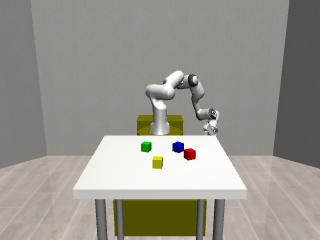

Goal qpos


""

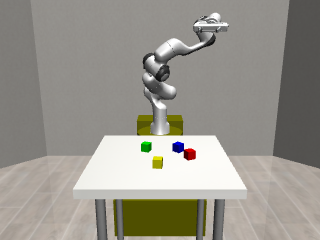

In [ ]:
init_qpos = None
goal_qpos = None

while True:
  init_qpos = sampler()
  if not collision(init_qpos):
    break
while True:
  goal_qpos = sampler()
  if not collision(goal_qpos):
    break

print('Start qpos')
media.show_image(get_image_of_pos(init_qpos))

print('Goal qpos')
media.show_image(get_image_of_pos(goal_qpos))

In [ ]:
planner_1 = RRTStarPlanner(gamma=0.5, eta=0.1, epsilon=0.1)
planner_2 = RRTStarPlanner(gamma=0.5, eta=0.05, epsilon=0.1)
planner_3 = RRTStarPlanner(gamma=0.5, eta=0.01, epsilon=0.1)

planners = [planner_1, planner_2, planner_3]
paths = []
for index, planner in enumerate(planners):
  start = time.time()
  planner(sampler, collision, init_qpos, goal_qpos, max_iter=10000, threshold=0.05)
  end = time.time()
  if path:=planner.path:
    print(f'Planner {index+1} :: Find trajectory with length {len(path)} in time {end - start}.')
    paths.append(path)
  else:
    print(f'Planner {index+1} :: Failed to find trajectory. time: {end - start}')

Planner 1 :: Find trajectory with length 63 in time 13.686527967453003.
Planner 2 :: Find trajectory with length 114 in time 7.1827123165130615.
Planner 3 :: Find trajectory with length 612 in time 6.557694673538208.


In [ ]:
for path in paths:
  frames = [get_image_of_pos(path[0]) for _ in range(len(path)//10)]
  frames = frames + [get_image_of_pos(pos) for pos in path]
  frames = frames + [get_image_of_pos(path[-1]) for _ in range(len(path)//10)]

  media.show_video(frames, fps=len(path)/5)

The video above was *__not__* controlled using a PID controller.

# Cartesian Planner



**Specifications**:

1. **Class Definition**:
    - **Class Name**: `CartesianPlanner`

2. **Constructor Parameters**:
    - `damping`: A damping factor used in the Damped Least Squares (DLS) method for inverse kinematics (default: 0.01).
    - `goal_tolerance`: Tolerance for considering the goal position reached (default: 0.01).

3. **Methods**:
    - `__init__(self, damping: float = 0.01, goal_tolerance: float = 0.01)`: Initializes the planner with the given parameters.
    - `__call__(self, sampler: Sampler, collision: CollisionChecker, kinematics: Kinematics, init_qpos: npt.NDArray, goal_pos: npt.NDArray, goal_rot: npt.NDArray, eef_id: int = None, resolution: int = 1, n_step: int = 100, max_iter: int = 10, threshold: float = 1e-12)`: Plans a path from the initial configuration to the goal pose.
    - `generate_waypoints(self, init_pos, init_rot, goal_pos, goal_rot, n_step, is_slerp=False) -> list[tuple[npt.NDArray, npt.NDArray]]`: Generates waypoints from the initial pose to the goal pose.

In [ ]:
def get_quaternion_from_matrix(R):
    # Ensure the input is a proper rotation matrix
    assert R.shape == (3, 3)

    # Calculate the trace of the matrix
    trace = np.trace(R)

    if trace > 0:
        s = 2.0 * np.sqrt(trace + 1.0)
        w = 0.25 * s
        x = (R[2, 1] - R[1, 2]) / s
        y = (R[0, 2] - R[2, 0]) / s
        z = (R[1, 0] - R[0, 1]) / s
    elif (R[0, 0] > R[1, 1]) and (R[0, 0] > R[2, 2]):
        s = 2.0 * np.sqrt(1.0 + R[0, 0] - R[1, 1] - R[2, 2])
        w = (R[2, 1] - R[1, 2]) / s
        x = 0.25 * s
        y = (R[0, 1] + R[1, 0]) / s
        z = (R[0, 2] + R[2, 0]) / s
    elif R[1, 1] > R[2, 2]:
        s = 2.0 * np.sqrt(1.0 + R[1, 1] - R[0, 0] - R[2, 2])
        w = (R[0, 2] - R[2, 0]) / s
        x = (R[0, 1] + R[1, 0]) / s
        y = 0.25 * s
        z = (R[1, 2] + R[2, 1]) / s
    else:
        s = 2.0 * np.sqrt(1.0 + R[2, 2] - R[0, 0] - R[1, 1])
        w = (R[1, 0] - R[0, 1]) / s
        x = (R[0, 2] + R[2, 0]) / s
        y = (R[1, 2] + R[2, 1]) / s
        z = 0.25 * s

    return np.array([w, x, y, z])

def get_matrix_from_quaternion(quat):
  w, x, y, z = quat
  R = np.array([
    [2 * (w**2 + x**2) - 1, 2 * (x * y - w * z), 2 * (x * z + w * y)],
    [2 * (x * y + w * z), 2 * (w**2 + y**2) - 1, 2 * (y * z - w * x)],
    [2 * (x * z - w * y), 2 * (y * z + w * x), 2 * (w**2 + z**2) - 1],
  ])
  return R

def get_linear_interpoation(postionA, postionB, step):
  postionA = np.asarray(postionA)
  postionB = np.asarray(postionB)
  return postionB * step + postionA * (1 - step)

def get_quaternion_inverse(quaternion):
  q = np.array(quaternion, dtype=np.float64, copy=True)
  np.negative(q[1:], q[1:])
  return q / np.dot(q, q)

def get_quaternion_slerp(qA, qB, t):
  if isinstance(qA, (np.ndarray, list)) and isinstance(qB, (np.ndarray, list)):
    qA = np.asarray(qA)
    qB = np.asarray(qB)
    if qA.shape != (4,):  # quaternion
      raise ValueError("Expecting the shape of the orientation to be (4,)")
    if qB.shape == (0,):
      qB = np.asarray([1.0, 0.0, 0.0, 0.0])

    a = qB * get_quaternion_inverse(qA)
    result = np.sign(a) * (np.abs(a)) ** t * qA
    return result

In [ ]:
class CartesianPlanner:
  def __init__(self, damping: float = 0.01, goal_tolerance: float = 0.01):
    self.damping = damping
    self.goal_tolerance = goal_tolerance
    self.path = []

  def __call__(self, sampler: Sampler, collision: CollisionChecker, kinematics: Kinematics, init_qpos: npt.NDArray, goal_pos: npt.NDArray, goal_rot: npt.NDArray, eef_id: int = None, resolution: int = 1, n_step: int = 100, max_iter: int = 10, threshold: float = 1e-12) -> None:
    self.path = []
    init_pos, _, init_rot = kinematics.forward(init_qpos, eef_id)
    waypoints = self.generate_waypoints(init_pos, init_rot, goal_pos, goal_rot, n_step)

    nv = kinematics.model.nv
    body_ids = kinematics.body_ids
    joint_ids = kinematics.model.body_jntadr[body_ids]
    joint_ids = [id for id in joint_ids if id != -1]
    qpos_adrs = kinematics.model.jnt_qposadr[joint_ids]
    qvel_adrs = kinematics.model.jnt_dofadr[joint_ids]
    jac_data = mujoco.MjData(kinematics.model)
    jac_data.qpos[:] = collision.data.qpos.copy()
    jacp = np.zeros((3, nv))
    jacr = np.zeros((3, nv))
    dof = kinematics.get_total_dof_of_body_ids(body_ids)

    collision_flag = False
    damping = self.damping
    for _ in range(max_iter):
      current_qpos = init_qpos.copy()
      joint_path = [current_qpos]
      jac_data.qpos[qpos_adrs] = current_qpos
      mujoco.mj_forward(kinematics.model, jac_data)
      current_pos = jac_data.body(body_ids[-1]).xpos.copy()
      current_rot = jac_data.body(body_ids[-1]).xmat.copy().reshape([3,3])

      for step, (pos, rot) in enumerate(waypoints):
        err_pose = calc_pose_error(pos, rot, current_pos, current_rot, threshold)

        mujoco.mj_jac(kinematics.model, jac_data, jacp, jacr, current_pos, body_ids[-1])
        J = np.vstack([jacp[:, qvel_adrs[0]:qvel_adrs[0]+dof], jacr[:, qvel_adrs[0]:qvel_adrs[0]+dof]])
        J_dls = np.dot(J.T, np.linalg.inv(np.dot(J, J.T) + damping ** 2 * np.identity(6)))
        dq = np.dot(J_dls, err_pose)
        current_qpos = current_qpos + dq.reshape([-1])

        if collision(current_qpos):
          collision_flag = True
          break

        jac_data.qpos[qpos_adrs] = current_qpos
        mujoco.mj_forward(kinematics.model, jac_data)
        current_pos = jac_data.body(body_ids[-1]).xpos.copy()
        current_rot = jac_data.body(body_ids[-1]).xmat.copy().reshape([3,3])

        if current_qpos in sampler:
          if step % (1 / resolution) == 0 or step == len(waypoints) - 1:
            joint_path.append(current_qpos)
      else:
          err = np.linalg.norm(goal_pos - current_pos)
          if err < self.goal_tolerance:
            break
      if collision_flag:
        joint_path = []
        break
    else:
      joint_path = []
    self.path = joint_path

  def generate_waypoints(self, init_pos, init_rot, goal_pos, goal_rot, n_step, is_slerp = False) -> list[tuple[npt.NDArray, npt.NDArray]]:
    waypoints = []
    if is_slerp:
      init_ori = get_quaternion_from_matrix(init_rot)
      goal_ori = get_quaternion_from_matrix(goal_rot)

    for step in range(1, n_step + 1):
      delta_t = step / n_step
      pos = get_linear_interpoation(init_pos, goal_pos, delta_t)
      rot = init_rot
      if is_slerp:
        quat = get_quaternion_slerp(init_ori, goal_ori, delta_t)
        rot = get_matrix_from_quaternion(quat)
      waypoints.append((pos, rot))
    return waypoints

Init qpos


""

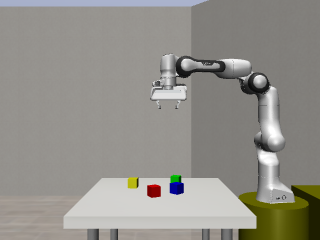

2.7627261656657825e-06
4.2705618513609987e-07
3.577702715365389e-07


In [ ]:
mujoco.mj_resetDataKeyframe(model, data, key)
mujoco.mj_forward(model, data)

init_qpos = data.qpos[qpos_adrs]

print('Init qpos')
media.show_image(get_image_of_pos(init_qpos, 'sideview'))

cartesian_goals = []
for axis in range(3):
  goal_pos, _, goal_rot = kinematics.forward(init_qpos)
  goal_pos[axis] = goal_pos[axis] - 0.1
  cartesian_goal_qpos = kinematics.inverse(init_qpos, goal_pos, goal_rot)
  if cartesian_goal_qpos is not None and cartesian_goal_qpos in sampler:
    cartesian_goals.append((goal_pos, goal_rot))

In [ ]:
planner = CartesianPlanner()
paths = []
axis_name = ['X', 'Y', 'Z']
for index, (pos, rot) in enumerate(cartesian_goals):
    start = time.time()
    planner(sampler, collision, kinematics, init_qpos, pos, rot, n_step=100)
    end = time.time()
    if path:=planner.path:
        print(f'Path to move {axis_name[index]}-axis :: Find trajectory with length {len(path)} in time {end - start}.')
        paths.append(path)
    else:
        print(f'Path to move {axis_name[index]}-axis :: Failed to find trajectory. time: {end - start}')

Path to move X-axis :: Find trajectory with length 101 in time 0.04518532752990723.
Path to move Y-axis :: Find trajectory with length 101 in time 0.040555477142333984.
Path to move Z-axis :: Find trajectory with length 101 in time 0.03877115249633789.


In [ ]:
views = ['sideview', 'frontview', 'frontview']
for path, view in zip(paths, views):
    frames = [get_image_of_pos(path[0], view) for _ in range(len(path)//10)]
    frames = frames + [get_image_of_pos(pos, view) for pos in path]
    frames = frames + [get_image_of_pos(path[-1], view) for _ in range(len(path)//10)]

    media.show_video(frames, fps=len(path)/5)

The video above was *__not__* controlled using a PID controller.

# Object Grasp Planning

#Find an object's pose in MuJoCo environment

In a MuJoCo simulation environment, you often need to retrieve the positions and orientations of various objects (bodies) within the simulation. This information is crucial for tasks such as control, visualization, and analysis. Given a list of body names, write a Python function that:

Retrieves the body IDs for the given body names.
Extracts the positions and orientations (quaternions) of these bodies.
Stores and returns this information in a dictionary.

1. `get_body_names(model)`: Retrieves and returns a list of all body names in the MuJoCo model.
2. `get_body_poses(model, data, body_names)`: Takes a list of body names and returns a dictionary with their positions and orientations.

In [ ]:
def get_body_names(model):
    """
    Retrieve all body names from the MuJoCo model.

    Parameters:
        model: MuJoCo model object.

    Returns:
        List of body names.
    """
    body_names = []
    # Iterate through all bodies in the model
    for i in range(model.nbody):
        # Get the name of the body with index i
        name = mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_BODY, i)
        if name:
            # Add the body name to the list if it exists
            body_names.append(name)
    return body_names

def get_body_poses(model, data, body_names):
    """
    Retrieve the positions and orientations of specified bodies.

    Parameters:
        model: MuJoCo model object.
        data: MuJoCo data object.
        body_names: List of body names to retrieve poses for.

    Returns:
        Dictionary with body names as keys and their poses as values.
    """
    body_poses = {}
    # Iterate through the list of body names
    for body_name in body_names:
        # Get the ID of the body with the given name
        body_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, body_name)
        # Get the position of the body
        position = data.body(body_id).xpos
        # Get the orientation of the body (quaternion)
        orientation = data.body(body_id).xquat
        # Store the position and orientation in the dictionary
        body_poses[body_name] = {'position': position, 'orientation': orientation}
    return body_poses

# Initialize the MuJoCo model and data
model_path = './panda_mjcf/panda_4cube.xml'  # Provide the path to your MuJoCo model file
model = mujoco.MjModel.from_xml_path(model_path)
data = mujoco.MjData(model)

# Reset the data to the initial keyframe
mujoco.mj_resetDataKeyframe(model, data, 0)
# Forward the simulation to update the data
mujoco.mj_forward(model, data)

# List of body names to get poses for
body_names = ['red_cube', 'hand']  # Replace with actual body names in your MuJoCo environment

# Get the poses of the specified bodies
body_poses = get_body_poses(model, data, body_names)

# Print the poses
for body_name, pose in body_poses.items():
    print(f"Pose of {body_name}:")
    print(f"  Position: {pose['position']}")
    print(f"  Orientation (quaternion): {pose['orientation']}")

Pose of red_cube:
  Position: [0.03  0.172 0.85 ]
  Orientation (quaternion): [0.973 0.    0.    0.23 ]
Pose of hand:
  Position: [-0.046 -0.     1.375]
  Orientation (quaternion): [0.    0.707 0.707 0.   ]


#Compute grasp poses to grasp an object in MuJoCo environment

> 인용구 추가


In this problem, you are required to compute the necessary poses for a robotic gripper to grasp an object in a MuJoCo simulation. The solution will involve:

1. Computing the grasp pose for the gripper.
2. Computing the pre-grasp and post-grasp poses.
3. Solving the inverse kinematics for the pre-grasp pose.

- Pre-Grasp Pose
The pre-grasp pose is an intermediate pose where the gripper is positioned slightly above the object. This pose is used to ensure that the gripper can move down smoothly and accurately to the grasp pose. It helps avoid collisions and provides a controlled approach to grasping.

- Post-Grasp Pose
The post-grasp pose is the pose that the gripper assumes immediately after successfully grasping the object. This pose is used to lift the object slightly to ensure it is securely held before any further manipulation or movement.

3.7940327293459226e-08
Gripper Pose:
  Position: [0.03  0.172 0.97 ]
  Orientation (quaternion): [0.    0.707 0.707 0.   ]
Pre Gripper Pose:
  Position: [0.03  0.172 1.   ]
  Orientation (quaternion): [0.    0.707 0.707 0.   ]


""

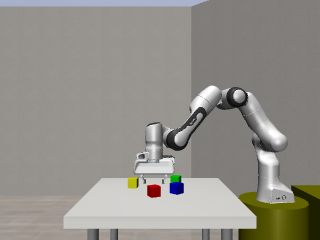

""

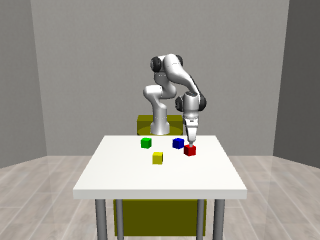

""

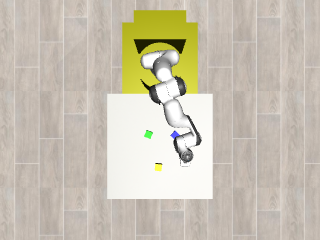

In [ ]:
def compute_gripper_pose_for_grasping_cube(cube_pos, cube_quat, gripper_quat, height_above_cube=0.12):
    """
    Compute the gripper pose for grasping a cube.

    Parameters:
        cube_pos (array): Position of the cube [x, y, z].
        cube_quat (array): Orientation of the cube in quaternion [w, x, y, z].
        gripper_quat (array): Orientation of the gripper in quaternion [w, x, y, z].
        height_above_cube (float): Height above the cube for the gripper.

    Returns:
        tuple: Final gripper position, quaternion, and rotation matrix.
    """
    # Compute the new gripper position for grasping
    gripper_pos = np.array(cube_pos)
    # Adjust to a suitable height above the cube base
    gripper_pos[2] += height_above_cube

    # Compute the relative rotation needed to align the gripper with the cube's orientation
    cube_rot = get_matrix_from_quaternion(cube_quat)
    gripper_rot = get_matrix_from_quaternion(gripper_quat)
    relative_rot = np.dot(np.linalg.inv(cube_rot), gripper_rot)

    # Combine the gripper's downward orientation with the cube's orientation
    final_rot = np.dot(cube_rot, relative_rot)

    # Return the final gripper position, quaternion, and rotation matrix
    return gripper_pos, get_quaternion_from_matrix(final_rot), final_rot



# Retrieve the cube and gripper positions and orientations from the body poses
cube_position = body_poses['red_cube']['position']
cube_orientation = body_poses['red_cube']['orientation']
hand_position = body_poses['hand']['position']
hand_orientation = body_poses['hand']['orientation']

# Compute the gripper pose for grasping the cube
gripper_position, gripper_orientation, gripper_rot = compute_gripper_pose_for_grasping_cube(cube_position, cube_orientation, hand_orientation)

# Compute the pre-grasp pose (slightly above the final grasp pose)
pre_gripper_position, pre_gripper_orientation, pre_gripper_rot = copy.deepcopy(gripper_position), copy.deepcopy(gripper_orientation), copy.deepcopy(gripper_rot)
pre_gripper_position[2] += 0.03

# Reset the simulation data and forward the simulation to update the state
mujoco.mj_resetDataKeyframe(model, data, 0)
mujoco.mj_forward(model, data)

# Initialize the kinematics solver with the model and body IDs
kinematics = Kinematics(model, body_ids)

# Sample the current joint positions
sample = data.qpos[qpos_adrs]

# Solve the inverse kinematics for the pre-grasp pose
pre_grasp_qpos = kinematics.inverse(sample, pre_gripper_position, pre_gripper_rot, max_iter=200)

# Print the computed gripper poses
print("Gripper Pose:")
print(f"  Position: {gripper_position}")
print(f"  Orientation (quaternion): {gripper_orientation}")
print("Pre Gripper Pose:")
print(f"  Position: {pre_gripper_position}")
print(f"  Orientation (quaternion): {pre_gripper_orientation}")

# Visualize the pre-grasp pose from different camera views
views = ['sideview', 'frontview', 'birdview']
for view in views:
    media.show_image(get_image_of_pos(pre_grasp_qpos, view))

#Find a path from an initial pose to the grasp pose
In this problem, you are required to plan a path to execute the grasping.
- Path Planning Recommendations:
1. From the initial to the pre-grasp pose: Use RRT* (Rapidly-exploring Random Tree) for path planning.
2. From the pre-grasp pose to the grasp pose: Use Cartesian planning for a straight-line approach.
3. From the grasp pose to the post-grasp pose: Reverse the Cartesian plan.
4. From the post-grasp pose to the initial pose: Reverse the RRT* plan.

In [ ]:
mujoco.mj_resetDataKeyframe(model, data, 0)
mujoco.mj_forward(model, data)
init_qpos = data.qpos[qpos_adrs] # Initial Configuration

cartesian_planner = CartesianPlanner() # Cartesian Planner
rrtstar_planner = RRTStarPlanner(gamma=0.5, eta=0.05, epsilon=0.1) # RRT* Planner

# Plan path using RRT*
rrtstar_planner(sampler, collision, init_qpos, pre_grasp_qpos, max_iter=10000, threshold=0.05)
path_rrt = rrtstar_planner.path

# Plan path using Cartesian planning
cartesian_planner(sampler, collision, kinematics, pre_grasp_qpos, gripper_position, gripper_rot, n_step=100)
path_cartesian = cartesian_planner.path

grasp_qpos = kinematics.inverse(sample, gripper_position, gripper_rot, max_iter=200)

full_path = (
    [init_qpos] * 5 +  # Initial waiting pose
    path_rrt +
    path_cartesian +
    [grasp_qpos] * 5 +  # Grasp pose
    list(reversed(path_cartesian)) +
    list(reversed(path_rrt)) +
    [init_qpos] * 5  # Return to initial pose
)

1.2554576922933225e-07


#Control a robot to follow the paths.
You will use path planning algorithms and a PID controller to simulate the robot's movements along these paths. The solution involves:

- Initializing the robot and controller.
- Following the paths.
- Simulating and visualizing the robot's movements.

In [ ]:
def simulate_path(model, data, path, controller):
    """
    Simulate the gripper following the planned path.

    Parameters:
        model: MuJoCo model object.
        data: MuJoCo data object.
        path: List of waypoints (joint configurations).
        controller: PID controller object.
    """
    FRAMERATE = 60  # Frames per second

    # Initialize a list to store frames for the video
    frames = []

    # Iterate through each waypoint in the path
    for qpos_idx, curr_qpos in enumerate(path):
        # Reset the controller with the current simulation time
        controller.reset(data.time)
        # Set the target position for the controller
        controller.x_trgt = curr_qpos.copy()

        while True:
            # Copy the current joint positions
            x_curr = data.qpos[qpos_adrs].copy()
            # Update the controller with the current positions and time
            controller.update(x_curr, data.time)
            # Set the control inputs for the actuators
            data.ctrl[ctrl_adrs] = controller.out()
            # Step the simulation forward
            mujoco.mj_step(model, data)


            # Render and save frames
            if len(frames) < data.time * FRAMERATE:
                renderer.update_scene(data, camera='sideview')
                pixels = renderer.render()
                frames.append(pixels)
            # Break if the current error is small enough
            if np.sum(np.abs(controller.err_curr)) < 0.07:
                break

    return frames

# Define a controller
pid_controller = PIDController(k_p=1000, k_i=0.1, k_d=50, dim=7, out_min=model.actuator_ctrlrange[ctrl_adrs, 0], out_max=model.actuator_ctrlrange[ctrl_adrs, 1])

# Initialize pose.
mujoco.mj_resetDataKeyframe(model, data, 0)

# Simulate paths and collect frames
frames = simulate_path(model, data, full_path, pid_controller)

# Display video.
media.show_video(frames, fps=FRAMERATE)